In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

In [13]:
#ARW functions
import numpy as np

#compute cdfhat(q)
def cdfhat(q, arr):
    count_leq = np.count_nonzero(arr <= q) 
    quantile = count_leq / len(arr)  
    return quantile

def cdfhat_arr(q, arr):
    q = q[:, np.newaxis]  # Convert q to column vector for broadcasting
    cdf_values = np.mean(arr <= q, axis=1)  # Broadcast comparison over arr and calculate mean
    return cdf_values

#compute psi_tk for all k
def compute_psi(Btk_all, alpha, delta):
    sigma_bin = alpha *(1-alpha) 

    #NOTE: this part can be changed
    psi_all = np.sqrt(2 * sigma_bin * np.log(1/delta) / Btk_all)
    #psi_1_all = 1.5 * np.sqrt(2 * sigma_bin * np.log(4/delta) / Btk_all) + (19/4) * np.log(4/delta) / Btk_all
    #psi_2_all = np.sqrt(2 * sigma_bin * np.log(4/delta) / Btk_all) + (19/6) * np.log(4/delta) / Btk_all

    return psi_all

# Compute summary statistics

def prepare(U, B_arr, alpha):

    """Compute B_tk, mu_hat_tk and v_hat_tk for all k
    Args:
        U (np.array): 1D array of length B_1 + ... + B_t
        B_arr: (np.array) stores the sample size for each period
        alpha: quantile level
        delta: exceptional probability
    Returns:
        Btk_all, qtk_all, Fti_qtk_all
    """

    period_ends = np.cumsum(B_arr)
    period_starts = period_ends - B_arr

    t = len(B_arr)
   
    #compute B_tk for each k
    #compute empirical quantiles for each k 
    #NOTE: np.quantile interpolates between samples
    qtk_all = np.array( [np.quantile( U[period_starts[i]:], 1-alpha) for i in range(t)] )[::-1]

    Fti_qtk_all = np.zeros((t,t))

    for i in range(t):
        Fti_qtk_all[i,:] = cdfhat_arr(qtk_all, U[period_starts[t-i-1]:])

    return qtk_all, Fti_qtk_all

# Goldenshluger-Lepski procedure

def ARWQE(U, B_arr, psi_all, alpha, gamma=1):

    """ Adaptive Rolling Window Mean Estimation(ARWME): selecting the best window size
    Args:
        U (np.array): 1D array of length B_1 + ... + B_t
        B_arr: (np.array) stores the sample size for each period
        alpha: quantile level
        delta: exceptional probability

    Returns:
        k_hat +1 (int): best window size
        qtk_all[k_hat] (float): best quantile estimate
    """

    # Compute B_tk, mu_tk and v_tk for all k
    qtk_all, Fti_qtk_all = prepare(U, B_arr, alpha)

    t = len(B_arr)
    
    # Compute phi_hat_k for all k
    phi_hat_all = np.empty(t)
    for k in range(t):

        #NOTE: this part can be changed
        tmp = np.array([ np.abs(Fti_qtk_all[i,k] - (1-alpha)) - (psi_all[k] - psi_all[i])*gamma for i in range(k + 1) ])
        #print(tmp<0)
        tmp[tmp < 0] = 0
        phi_hat_all[k] = np.max(tmp)

    # Choose k_hat
    k_hat = np.argmin(phi_hat_all + psi_all)
    return k_hat+1, qtk_all[k_hat], qtk_all

In [38]:
trials_per_var = 1
num_periods = 200
alpha = 0.1; delta = 0.1; gamma=1
fixed_windows = [1, 256]

#stationary case
true_means = 10 * np.ones(num_periods)

#NOTE: uncomment to change cases

#non-stationary case
true_means = generate_true_means(num_periods-1, 3)
#true_means = np.sin(np.linspace(0, 8*np.pi, num_periods)) + 5

#plt.plot(true_means)

B_arr = np.random.randint(low=1, high=2, size=num_periods)
B_arr_starts = np.cumsum(B_arr) - B_arr
B_arr_ends = np.cumsum(B_arr) - 1

Btk_all = np.cumsum(np.ones(num_periods))
print(len(Btk_all))
psi_all = compute_psi(Btk_all, alpha, delta)

#seeds for the trials
variances = [0.01]
seeds = np.arange(len(variances) * trials_per_var)

#initialize dictionary for storing the results
CDF_dict = {}
CDF_dict['ARW'] = {}
for k in fixed_windows:
    CDF_dict[f'Val_{k}'] = {}
    for variance in variances:
        CDF_dict[f'Val_{k}'][variance] = {}
        CDF_dict['ARW'][variance] = {}
        for trial in range(trials_per_var):
            CDF_dict[f'Val_{k}'][variance][trial] = []
            CDF_dict['ARW'][variance][trial] = []


for (trial, seed) in tqdm(enumerate(seeds)):

    np.random.seed(seed)
    variance = variances[trial // trials_per_var]

    U = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)

    #k_hat_all = []
    #true_cdfs = np.zeros(( num_periods, 1+len(fixed_windows)))
    
    for t in range(num_periods):
            
        mu_t = true_means[t]

        U_t = U[:B_arr_ends[t]+1]
        B_arr_t = B_arr[:t+1]

        khat, qt_khat, qtk_all = ARWQE(U_t, B_arr_t, psi_all[:t+1], alpha, gamma)
        #k_hat_all.append(khat)

        CDF_dict['ARW'][variance][trial % trials_per_var].append(norm.cdf(qt_khat, mu_t, np.sqrt(variance)))

        #baseline: take quantile of fixed k
        for ik, k in enumerate(fixed_windows):
            CDF_dict[f'Val_{k}'][variance][trial % trials_per_var].append(norm.cdf(qtk_all[min(k,t)], mu_t, np.sqrt(variance)))
            
    #k_hat_all = np.array(k_hat_all)

200


1it [00:03,  3.34s/it]


Variance: 0.01


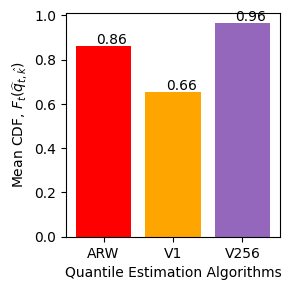

In [39]:
#process results
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
num_methods = len(methods)

#save result dictionary to numpy array
CDF_array = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
rel_error = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
for (i, key) in enumerate(CDF_dict.keys()):
    for (j, variance) in enumerate(CDF_dict[key].keys()):
        for (trial, trial_CDF) in CDF_dict[key][variance].items():
            #record square errors 
            CDF_array[i, j, trial, :] = trial_CDF

#take average of cdf over time and trials for each variance (n_model * n_variance)
cdf_mean_over_variances = np.mean(np.mean(CDF_array, axis=3), axis=2)

#take average of cdf over for each trial (n_model * n_variance * n_periods)
cdf_mean_over_trials = np.mean(CDF_array, axis=2)

#plot results
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF']

for (idx, variance) in enumerate(variances):
    print(f'Variance: {variance}')
    #for each variance, barplot mean MSE of each method
    fig, ax = plt.subplots(1, 1, figsize = (3, 3))    
    ax.bar(range(num_methods), cdf_mean_over_variances[:, idx], color=colors, \
           width = 0.8)
    #show number on yaxis
    for i, v in enumerate(cdf_mean_over_variances[:, idx]):
        ax.text(i - 0.1, v + 0.01, f'{v:.2f}', color='black')
    ax.set_xlabel('Quantile Estimation Algorithms')
    ax.set_xticks(range(num_methods))
    ax.set_xticklabels(['ARW', 'V1','V256'])
    ax.set_ylabel(r'Mean CDF, $F_t(\widehat{q}_{t,\hat{k}})$')
    mpl.rcParams.update({'font.size': 10})
    plt.tight_layout()
    plt.show()
    
    #uncomment to save the figure
    #plt.savefig(f'{DATAPATH}/{figname}_var{variance}.png', dpi=300, bbox_inches='tight')